<a href="https://colab.research.google.com/github/steveoni/collaboarative_model/blob/master/Netflix_recom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.3)


In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/


In [0]:
path = "~/"

In [3]:
! kaggle datasets download -d netflix-inc/netflix-prize-data

 99% 673M/682M [00:20<00:00, 21.3MB/s]
100% 682M/682M [00:20<00:00, 35.0MB/s]


In [0]:
! unzip -q -n netflix-prize-data.zip

In [0]:
import pandas as pd
import numpy as np
import math

**Data Gathering and cleaning**

In [6]:
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [8]:
df = df1.copy()
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [9]:
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


In [10]:

df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
# df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

   Movie_Id    Year                          Name
0         1  2003.0               Dinosaur Planet
1         2  2004.0    Isle of Man TT 2004 Review
2         3  1997.0                     Character
3         4  1994.0  Paula Abdul's Get Up & Dance
4         5  2004.0      The Rise and Fall of ECW
5         6  1997.0                          Sick
6         7  1992.0                         8 Man
7         8  2004.0    What the #$*! Do We Know!?
8         9  1991.0      Class of Nuke 'Em High 2
9        10  2001.0                       Fighter


In [0]:
ratings = df.merge(df_title[['Movie_Id','Name']])

since the dataset is about  hundrend of millions , i take the subset of 900k

In [0]:
ratings = ratings.iloc[:900000,:]

In [12]:
ratings.head(10)

,Cust_Id,Rating,Movie_Id,Name
0,1488844,3.0,1,Dinosaur Planet
1,822109,5.0,1,Dinosaur Planet
2,885013,4.0,1,Dinosaur Planet
3,30878,4.0,1,Dinosaur Planet
4,823519,3.0,1,Dinosaur Planet
5,893988,3.0,1,Dinosaur Planet
6,124105,4.0,1,Dinosaur Planet
7,1248029,3.0,1,Dinosaur Planet
8,1842128,4.0,1,Dinosaur Planet
9,2238063,3.0,1,Dinosaur Planet


In [13]:
print(ratings.iloc[::5000000, :])

          Cust_Id  Rating  Movie_Id                  Name
0         1488844     3.0         1       Dinosaur Planet
5000000    501954     2.0       996               Yojimbo
10000000   404654     5.0      1962        50 First Dates
15000000   886608     2.0      2876      Addicted to Love
20000000  1193835     2.0      3825  The Sum of All Fears


import fastai library

In [0]:
from fastai.collab import *
from fastai.tabular import *

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, item_name="Name",user_name="Cust_Id",rating_name="Rating")

In [81]:
data.show_batch()

Cust_Id,Name,target
1925195,Sweet November,3.0
851231,Record of Lodoss War: Chronicles of the Heroic Knight,2.0
260445,What the #$*! Do We Know!?,1.0
1561857,X2: X-Men United,4.0
1458665,Taking Lives,5.0


In [83]:
ratings["Cust_Id"].nunique()

276097

In [0]:
y_range = [0.5,5.5] # make the sigmoid output a little smaller and higher than the normal rating output

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


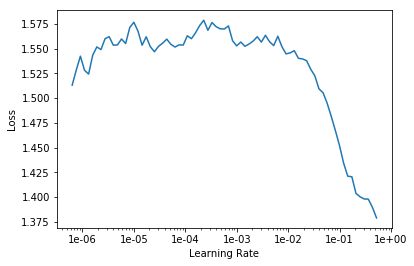

In [86]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [87]:
learn.fit_one_cycle(6, 5e-2)

epoch,train_loss,valid_loss,time
0,1.032733,1.032932,01:53
1,1.048324,1.084774,01:50
2,1.060365,1.054674,01:50
3,1.029518,1.019010,01:51
4,0.994851,0.990677,01:51
5,0.945098,0.952066,01:53


In [88]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(265863, 50)
  (i_weight): Embedding(200, 50)
  (u_bias): Embedding(265863, 1)
  (i_bias): Embedding(200, 1)
)

In [0]:
title = "Name"

In [90]:
g = ratings.groupby(title)['Rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(["Something's Gotta Give", 'X2: X-Men United', 'Reservoir Dogs', 'Taking Lives', 'Lilo and Stitch', 'The Game',
       'Duplex (Widescreen)', 'Sweet November', 'Death to Smoochy', 'Rambo: First Blood Part II'], dtype=object)

In [91]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([199])

In [0]:
(user,items), ratings = next(iter(data.valid_dl))
user = user.cpu()
items = items.cpu()
learn.model = learn.model.cpu()
preds = learn.model(user,items)

In [49]:
preds

tensor([3.8036, 3.8036, 3.2179, 3.8036, 3.7533, 3.8036, 3.8036, 3.8300, 3.8036,
        2.1991, 3.0251, 3.7945, 2.9778, 3.2179, 3.0070, 3.8036, 3.6796, 3.6915,
        3.8036, 3.8036, 3.8036, 3.5807, 3.7923, 3.2860, 3.7945, 3.2179, 3.8036,
        3.7533, 1.7016, 2.9053, 3.8036, 3.8036, 3.3863, 3.7945, 3.2179, 2.9053,
        3.8036, 3.2179, 3.6122, 3.2179, 3.4004, 3.8036, 3.8803, 3.7945, 2.9053,
        3.8036, 2.7374, 3.9776, 3.0241, 4.1045, 3.6991, 3.1305, 3.8484, 3.8036,
        3.6144, 3.6785, 3.7533, 3.8036, 3.7360, 3.5974, 3.8036, 3.8036, 4.0683,
        3.8036])

In [55]:
items

tensor([15, 15, 30, 15, 27, 15, 15, 15, 15, 21,  1, 12, 17, 30, 11, 15,  9,  5,
        15, 15, 15,  5, 15, 30, 12, 30, 15, 27,  3,  1, 15, 15, 30, 12, 30,  1,
        15, 30, 27, 30, 30, 15, 12, 12,  1, 15, 21, 15, 26, 15, 12, 30, 12, 15,
        15, 12, 27, 15, 27, 14, 15, 15, 12, 15])

check the inference of the rating for a single user

In [0]:
user = torch.tensor([3])
items = torch.tensor([30])

In [0]:
p = learn.model(user,items)

In [58]:
p

tensor([3.3497])

In [0]:
mean_ratings = ratings.groupby(title)['Rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [97]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.5539), 'Daydream Obsession', 2.0511221945137157),
 (tensor(-0.4918), 'Darkwolf', 2.1481481481481484),
 (tensor(-0.4661), 'The Bonesetter', 1.6754385964912282),
 (tensor(-0.4634), 'Sleepover Nightmare', 1.9545454545454546),
 (tensor(-0.4057), 'Iron Monkey 2', 1.9545454545454546),
 (tensor(-0.4006), 'The Libertine', 2.1491525423728812),
 (tensor(-0.3586), 'Horror Vision', 1.6344086021505377),
 (tensor(-0.3396),
  'Cannibal Women in the Avocado Jungle of Death',
  2.420765027322404),
 (tensor(-0.3241), 'Lost in the Pershing Point Hotel', 2.3294573643410854),
 (tensor(-0.3210), 'Love Reinvented', 2.4361702127659575),
 (tensor(-0.3105), 'Chump Change', 2.2463054187192117),
 (tensor(-0.3089), 'Barbarian Queen 2', 2.2951807228915664),
 (tensor(-0.2920), 'The Last Shot', 2.6000562113546937),
 (tensor(-0.2762), 'Searching for Paradise', 2.328125),
 (tensor(-0.2733), 'Where Sleeping Dogs Lie', 2.16793893129771)]

In [98]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.8648), 'Aqua Teen Hunger Force: Vol. 1', 4.168650217706822),
 (tensor(0.8340), 'The Chorus', 4.0922303573379954),
 (tensor(0.8058), 'Reservoir Dogs', 4.003847429519071),
 (tensor(0.7723), 'Invader Zim', 4.14259927797834),
 (tensor(0.7365), 'I Love Lucy: Season 2', 4.090385917400136),
 (tensor(0.7365), 'X2: X-Men United', 3.932202188006483),
 (tensor(0.7261), 'A Little Princess', 3.9340755293604017),
 (tensor(0.7244),
  "ABC Primetime: Mel Gibson's The Passion of the Christ",
  4.071736785329018),
 (tensor(0.6980),
  'Stevie Ray Vaughan and Double Trouble: Live at Montreux 1982 & 1985',
  4.097872340425532),
 (tensor(0.6717), 'Mostly Martha', 3.87182829336114),
 (tensor(0.6698), 'Star Trek: Voyager: Season 1', 3.9422340602630266),
 (tensor(0.6651), 'The Game', 3.853031645899588),
 (tensor(0.6585),
  'Richard Pryor: Live on the Sunset Strip',
  3.9169572798605055),
 (tensor(0.6302),
  'Inspector Morse 31: Death Is Now My Neighbour',
  3.9701739850869924),
 (tensor(0.6157), 'Li

Movie weight

In [99]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([199, 50])

In [100]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([199, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [102]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9007), 'The Killing'),
 (tensor(0.8868), 'The Bonesetter'),
 (tensor(0.8657), 'Chump Change'),
 (tensor(0.7263), 'IFilm: Deranged'),
 (tensor(0.7243), 'Ninotchka'),
 (tensor(0.6779), 'Chain of Fools'),
 (tensor(0.6716), 'Magnolia: Bonus Material'),
 (tensor(0.6487), 'The Libertine'),
 (tensor(0.6200), 'Vampire Journals'),
 (tensor(0.6039), 'Marilyn Manson: Fear of a Satanic Planet')]

In [103]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.9173), 'Taking Lives'),
 (tensor(-1.6608), 'Congo'),
 (tensor(-1.5931), 'Rambo: First Blood Part II'),
 (tensor(-1.5198), 'Dragonheart'),
 (tensor(-1.4840), 'Sweet November'),
 (tensor(-1.2965), "Something's Gotta Give"),
 (tensor(-1.2594), 'Lilo and Stitch'),
 (tensor(-1.2248), 'Fatal Beauty'),
 (tensor(-1.2015), 'Jingle All the Way'),
 (tensor(-1.1569), 'X2: X-Men United')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [105]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.4451), 'Reservoir Dogs'),
 (tensor(1.2465), 'Aqua Teen Hunger Force: Vol. 1'),
 (tensor(1.0596), 'Invader Zim'),
 (tensor(1.0110), 'The Rise and Fall of ECW'),
 (tensor(0.7616), 'Scratch'),
 (tensor(0.7293), 'Record of Lodoss War: Chronicles of the Heroic Knight'),
 (tensor(0.6848), 'Husbands and Wives'),
 (tensor(0.6827), 'The Powerpuff Girls Movie'),
 (tensor(0.6282), 'Death to Smoochy'),
 (tensor(0.6202), 'Richard Pryor: Live on the Sunset Strip')]

In [74]:
len(top_movies)

30

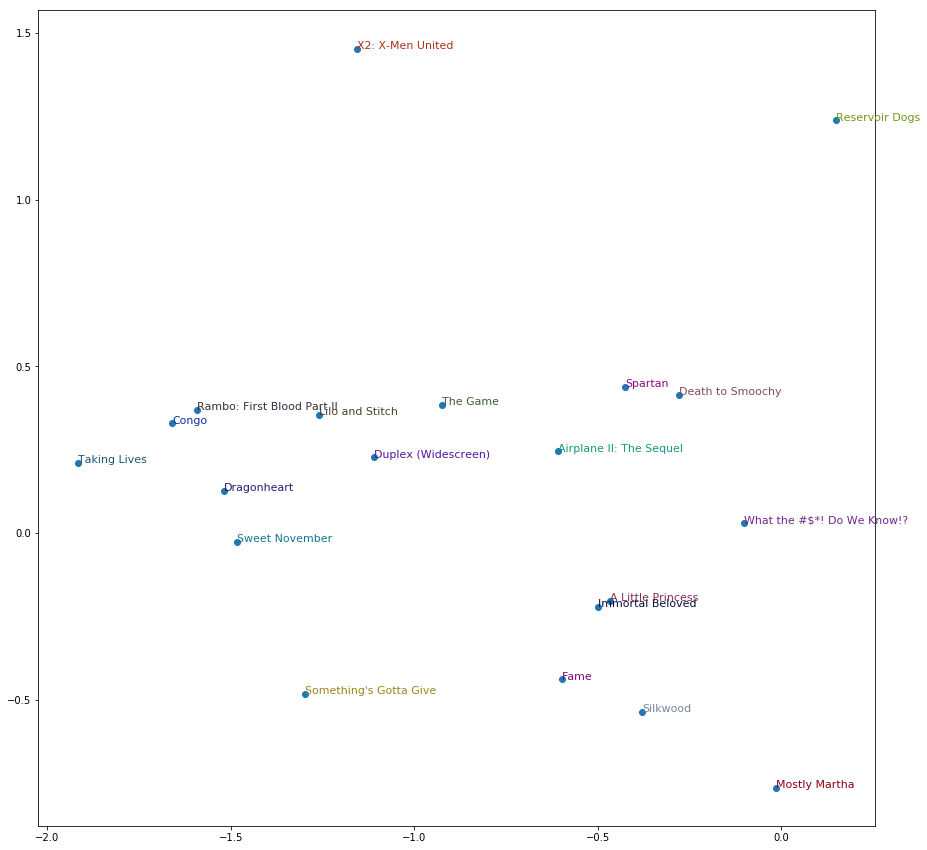

In [106]:
idxs = np.random.choice(len(top_movies), 20, replace=False)
idxs = list(range(20))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()